# import data in...

In [1]:
# Here are the links to the data (github has an upload limit)
# https://www.kaggle.com/c/facial-keypoints-detection/data


import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random as random
%matplotlib inline 

data = pd.read_csv('data/training.csv')
print('data loaded')

data loaded


# Convert the csv data into an images array and a labels array of batch_size length

In [2]:
# misc variables and sizes of data
images_count = data.iloc[0:,30:].shape[0]  # images_count = 7049
image_strings = data.iloc[0:,30:].values
labels = data.iloc[:, 0:30].values
image_array_size = len(image_strings[0,0].split(' ')) # image_array_size = 9216
desired_locations_count = 30
image_width = image_height = int(np.sqrt(image_array_size)) # image height/width = 96.0
batch_size = 50

# get a batch of images and labels
def get_batch(batch_size):
    tmpImages = []
    tmpLabels = []
    for i in range(0, batch_size):
        rndInt = random.randint(0, batch_size)
        image = image_strings[rndInt,0].split(' ')
        image = [float(i) for i in image]
        image = [i*(1/255) for i in image]
        tmpImages.append(image)
        tmpLabels.append(labels[rndInt])
    return (np.asarray(tmpImages),np.asarray(tmpLabels))    
    

print('made an images tensor as well as a labels tensor for all images in batch')

made an images tensor as well as a labels tensor for all images in batch


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


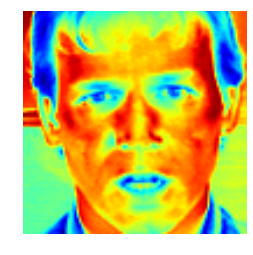

In [3]:
def display(img):
    sq = np.sqrt(img.shape)
    one_image = img.reshape(sq, sq)
    plt.axis('off')
    plt.imshow(one_image) #, cmap='Greys', clim = (-1.0,1.0))
    plt.show()


imag = image_strings[21,0].split(' ')
imag = [float(i) for i in imag]
imag = [i*(1/255) for i in imag]
imag = np.asarray(imag)
    
    
display(imag)

# set up our CNN methods

In [4]:
# set up our weights (or kernals?) and biases for each pixel
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(.1, shape=shape, dtype=tf.float32)
    return tf.Variable(initial)

# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, [1,1,1,1], 'SAME')

# pooling
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# placeholder variables
# images
x = tf.placeholder(tf.float32, shape=[None, image_array_size])

# labels
y_ = tf.placeholder(tf.float32, shape=[None, desired_locations_count])

print('methods defined')

methods defined


# build a Convolutional Neural Network

In [5]:
# ----------------first convolutional layer---------------------------
W_conv1 = weight_variable([15, 15, 1, 32])
b_conv1 = bias_variable([32])

# turn shape(images_count,9216)  into   (?,96,96,1) ... so it will work with the conv2d method
image = tf.reshape(x, [-1,image_width , image_height,1])
# print (image.get_shape()) # =>(?,96,96,1)

h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
# print (h_conv1.get_shape()) # => (?, 96, 96, 32)

h_pool1 = max_pool_2x2(h_conv1)
# print (h_pool1.get_shape()) # => (?, 48, 48, 32)




#-------------------------- second convolutional layer-----------------
W_conv2 = weight_variable([15, 15, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
# print (h_conv2.get_shape()) # => (?, 48,48, 64)
h_pool2 = max_pool_2x2(h_conv2)
# print (h_pool2.get_shape()) # => (?, 24, 24, 64)



#-------------------------fully connected layer-----------------------
W_fc1 = weight_variable([24 * 24 * 64, 1024])
b_fc1 = bias_variable([1024])

# (?, 24, 24, 64) => (?, 36864)
h_pool2_flat = tf.reshape(h_pool2, [-1, 24*24*64])
# print h_pool2_flat.get_shape() = (?, 36864)

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
# print (h_fc1.get_shape()) # => (?, 1024)



# ---------------------------------readout layer-------------------------------
W_fc2 = weight_variable([1024, desired_locations_count])
b_fc2 = bias_variable([desired_locations_count])

readout_layer = (tf.matmul(h_fc1, W_fc2) + b_fc2)
# print (readout_layer.get_shape()) #=> (?, 30)



print('Convolutional Nueral Net Defined')

Convolutional Nueral Net Defined


# define training step and train!

In [6]:
prediction_delta = tf.reduce_sum(tf.abs(readout_layer - y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(prediction_delta)
# train_step = tf.train.GradientDescentOptimizer(.5).minimize(prediction_delta)


sess = tf.Session()
sess.run(tf.initialize_all_variables())

for i in range(0,2001):
    xx, yy = get_batch(1)
    sess.run(train_step, feed_dict={x: xx, y_: yy})
    if(i%100 == 0):
        print('prediction_delta #' + str(i+1) + ': ' + str(sess.run(prediction_delta, feed_dict={x: xx, y_: yy})))
        print('first five labels: ' + str(yy[0,0:5]))
        print('first five predictions: ' + str(sess.run(readout_layer[0,0:5], feed_dict={x: xx, y_: yy})))


prediction_delta #1: 2729.03
first five labels: [ 66.03356391  39.00227368  30.22700752  36.4216782   59.58207519]
first five predictions: [ 102.38642883   21.97879982   20.77095032 -100.43199921 -202.75311279]
prediction_delta #101: 113.535
first five labels: [ 66.03356391  39.00227368  30.22700752  36.4216782   59.58207519]
first five predictions: [ 69.13690186  34.95246506  35.22046661  36.23862076  50.69379425]
prediction_delta #201: 80.4624
first five labels: [ 64.33293617  34.9700766   29.9492766   33.44871489  58.85617021]
first five predictions: [ 69.93792725  34.16031265  32.25943375  30.01481247  61.77392578]
prediction_delta #301: 50.2973
first five labels: [ 66.03356391  39.00227368  30.22700752  36.4216782   59.58207519]
first five predictions: [ 63.76532745  41.47404861  29.80457306  36.21302032  57.89188385]
prediction_delta #401: 68.8111
first five labels: [ 64.33293617  34.9700766   29.9492766   33.44871489  58.85617021]
first five predictions: [ 60.13674927  32.751644